In [1]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#pip install gensim --user

In [ ]:
# Run the following code if the package is not installed: "pip install num2words"
#!pip install num2words

In [ ]:
#pip install emoji

In [2]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import string
import re
import emoji
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import json

In [3]:
docs_path = 'inputs/dataset_tweets_WHO.txt'
with open(docs_path) as fp:
    tweets = json.loads(fp.read())

print("Number of tweets:", len(tweets))

Number of tweets: 2399


In [4]:
lang = {} 
for tweet in tweets:
    if tweets[tweet]['lang'] in lang:
        lang[tweets[tweet]['lang']] += 1
    else:
        lang[tweets[tweet]['lang']] = 1
        
print("Languages:", lang)
print(sum(lang.values()) == len(tweets)) # Check is the number of extracted languages is the same as the number of tweets

Languages: {'en': 2353, 'es': 19, 'in': 2, 'fr': 7, 'und': 1, 'tl': 1, 'de': 6, 'ar': 2, 'ru': 2, 'uk': 1, 'ps': 1, 'ja': 4}
True


In [7]:
def process_word(word, stop_words):
    """
    Preprocess each word of the tweet getting rid of URLs, punctuation sings and stop words
    
    Argument:
    word -- string (text) to be preprocessed
    stop_words -- list of stop words to get rid of
    
    Returns:
    word - the resulting processed word. False in case we don't want that word
    """
    
# Eliminate URLs
    word = re.sub(r'http\S+', '', word) 

# Eliminate ampersands
    word = re.sub(r'&\S+', '', word) 

    if not word:
        return False

# Get rid of punctuation marks except "#" and "@"
    if word[0] == '#':
        word = '#' + word.translate(str.maketrans('', '', string.punctuation)) 
        return word

    elif word[0] == '@':
        word = '@' + word.translate(str.maketrans('', '', string.punctuation)) 
        return word
    
    elif '¿' in word:
        word = word.replace('¿', '')
    
    else:
        word = word.translate(str.maketrans('', '', string.punctuation))

# Get rid of strings like '-'
    if len(word) <= 1 and not word.isdigit(): 
        return False
    
# Eliminate the stopwords 
    elif word not in stop_words: 
        return word

In [8]:

def build_terms(line):
    """
    Preprocess the tweet text calling the process_word function, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    
    stop_words = set()
    for lang in stopwords.fileids():
         stop_words |= set(stopwords.words(lang))
            
    line = emoji.get_emoji_regexp().sub("", line)
    
    line= line.lower()## Transform in lowercase
    line= line.split() ## Tokenize the text to get a list of terms
    templine=[]
    for word in line:      
        word = process_word(word, stop_words)
        if word:
            templine.append(word)
            
    line= templine
    line= [stemmer.stem(word) for word in line] ## perform stemming
    return line


In [9]:
def create_index_tfidf(tweets):
    """
    Implement the inverted index
    
    Argument:
    lines -- collection of tweets
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of tweets where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    tf = defaultdict(list)
    df = defaultdict(int)
    idf = defaultdict(float)
    num_tweets = len(tweets)
    
    for tweet in tweets:
        line = tweets[tweet]['full_text']
        line_arr = line.replace("\n", ' ')
        tweet_id = tweet
        terms = build_terms(''.join(line_arr))
        
        ## ===============================================================        
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_tweet_index ==> { ‘term1’: [current_tweet, [list of positions]], ...,‘term_n’: [current_tweet, [list of positions]]}

        ## Example: if the curr_tweet has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_tweet_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in tweet 1 in positions 0, 
        ## the term ‘retrieval’ appears in tweet 1 in positions 1 and 4
        ## ===============================================================

        current_tweet_index = {}

        for position, term in enumerate(terms):  ## terms contains the text of the tweet
            try:
                # if the term is already in the index for the current tweet (current_tweet_index)
                # append the position to the corresponding list
                current_tweet_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_tweet_index[term]=[tweet_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a tweet.
        norm = 0
        for term, posting in current_tweet_index.items():
            # posting will contain the list of positions for current term in current tweet. 
            # posting ==> [current_tweet, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_tweet_index.items():
            # append the tf for current term (tf = term frequency in current tweet/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the tweet frequency of current term (number of tweets containing the current term)
            df[term] += 1# increment DF for current term

        #merge the current tweet index with the main index
        for term_page, posting_page in current_tweet_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_tweets/df[term])), 4)

    return index, tf, df, idf

In [10]:
def check_index(word, index):
    if word in index:
        return index[word]
    else:
        return []

In [11]:
start_time = time.time() # Mark the time it takes for the code to create the indexes
index, tf, df, idf = create_index_tfidf(tweets)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 95.29 seconds


In [12]:
def rank_tweets(terms, tweets, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    tweets -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked tweets
    """
    # I'm interested only on the element of the tweetVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    tweet_vectors = defaultdict(lambda: [0] * len(terms)) # I call tweet_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue
            
        ## Compute tf*idf(normalize TF as done with tweets)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate tweet_vectors for matching tweets
        for tweet_index, (tweet, postings) in enumerate(index[term]):
            # Example of [tweet_index, (tweet, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in tweet 26 in positions 1,4, .....
            # term is in tweet 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the tweet 26            
            if tweet in tweets:
                tweet_vectors[tweet][termIndex] = tf[term][tweet_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each tweet 
    # compute the cosine similarity between queyVector and each tweetVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    tweet_scores=[[np.dot(curtweetVec, query_vector), tweet] for tweet, curtweetVec in tweet_vectors.items() ]
    tweet_scores.sort(reverse=True)

    result_tweets = [x[1] for x in tweet_scores]

    if len(result_tweets) == 0:
        print("No results found, try again")
        return False

    return result_tweets, tweet_scores

In [13]:
def query_output(query, index):
    
    query_words = build_terms(query)
    
    docs = {}
    for word in query_words:
        docs[word] = [val[0] for val in check_index(word, index)]
        if len(index[word]) == 0:
            return []
    
    doc_list = list(docs.values())
    final_doc_list = doc_list[0]
    for list_ in doc_list:
        final_doc_list = list(set(final_doc_list) & set(list_))
        
    ranked_tweets, tweet_scores = rank_tweets(query_words, final_doc_list, index, idf, tf)
    
    return ranked_tweets, tweet_scores
        
def display_tweets(list_):
    
    if len(list_) == 0:
        return 'No tweets'
    
    for tw in list_:
        print('\033[1m'+'Tweet index:'+'\033[0m', tw)
        print('\033[1m'+'Tweet:'+'\033[0m', tweets[tw]['full_text'])
        print('\033[1m'+'Username:'+'\033[0m', tweets[tw]['user']['name'])
        print('\033[1m'+'Date:'+'\033[0m', tweets[tw]['created_at'])
        print('\033[1m'+'Hashtags:'+'\033[0m', [d['text'] for d in tweets[tw]['entities']['hashtags']])
        print('\033[1m'+'Favourites:'+'\033[0m', tweets[tw]['user']['favourites_count']) # es el mes similar a likes que he trobat
        print('\033[1m'+'Retweets:'+'\033[0m', tweets[tw]['retweet_count'])
        print('\033[1m'+'URL:'+'\033[0m', 'https://twitter.com/'+tweets[tw]['user']['screen_name']+'/status/'+str(tweets[tw]['id']), '\n')
        print('\n')
    return

In [14]:
queries = ['covid19 vaccine', 'death risk', 'world pandemic', 'health service', 'developing countries']
tw_sc = []
for query_text in queries:
    out, scores = query_output(query_text, index)
    tw_sc.append(scores[:10])
    print(out[:10])
    print('\033[1m'+'Top 10 tweets from query "{}":'.format(query_text)+'\033[0m')
    display_tweets(out[:10])
    print("###############################################################\n\n")


['2257', '1959', '904', '1045', '2188', '2190', '935', '2195', '1772', '2186']
Top 10 tweets from query "covid19 vaccine":
Tweet index: 2257
Tweet: Q&amp;A #AskWHO on COVID-19 vaccines effectiveness https://t.co/FEdfOREhjn
Username: World Health Organization (WHO)
Date: Wed Jun 30 16:12:43 +0000 2021
Hashtags: ['AskWHO']
Favourites: 11879
Retweets: 85
URL: https://twitter.com/WHO/status/1410270080873598979 



Tweet index: 1959
Tweet: 💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉                 💉💉💉💉
💉💉💉💉                 💉💉💉💉

COVID-19 vaccines     COVID-19 vaccines
in 10 countries             in the rest of the 🌍

#VaccinEquity is 🗝️ to ending the pandemic, together!

#WorldEmojiDay
Username: World Health Organization (WHO)
Date: Sat Jul 17 16:24:23 +0000 2021
Hashtags: ['VaccinEquity', 'WorldEmojiDay']
Favourites: 11879
Retweets: 1517
URL: https://twitter.com/WHO/status/1416433609091653633 



Tweet index: 904
Tweet: #COVID19 variants &amp; vaccines:

✅ COVID-19 vaccines provide strong protection against

In [15]:
print("Insert your query:\n")
query = input()
ranked_tweets, tmp = query_output(query, index)
top = 10

if ranked_tweets:
    print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_tweets)))
    display_tweets(ranked_tweets[:10])


Insert your query:

health

Top 10 results out of 596 for the searched query:

Tweet index: 459
Tweet: #France 🇫🇷 supports strengthening health systems to achieve Universal Health Coverage, incl.:
✅Strengthening primary health care
✅Human resources for health
✅Financing of health systems
✅Access to health products
✅Research &amp; innovation

👉 https://t.co/salgMpDpkF https://t.co/EtRwdnaM8n
Username: World Health Organization (WHO)
Date: Mon Sep 27 12:27:56 +0000 2021
Hashtags: ['France']
Favourites: 11879
Retweets: 38
URL: https://twitter.com/WHO/status/1442466033131003908 



Tweet index: 657
Tweet: RT @DrTedros: #Qatar’s health workforce has been mobilized to provide health care in the compound, including immunization, mental health su…
Username: World Health Organization (WHO)
Date: Sun Sep 19 14:54:44 +0000 2021
Hashtags: ['Qatar']
Favourites: 11879
Retweets: 53
URL: https://twitter.com/WHO/status/1439603872058720261 



Tweet index: 2316
Tweet: To #BeatNCDs in SIDS, WHO calls for

In [16]:
aux = pd.DataFrame()
for i in tw_sc:
    t = pd.DataFrame(i)
    aux = aux.append(i)
aux = aux.rename(columns={0:'predicted_relevance', 1:'doc_id'})
aux = aux.astype({'predicted_relevance':'float', 'doc_id':'int'})


In [17]:
search_results = pd.read_csv("inputs/y_true.csv")
search_results.head()

,q_id,doc_id,y_true
0,0,2257,0
1,0,1959,1
2,0,904,1
3,0,1045,1
4,0,2188,1


In [18]:
search_results = pd.merge(search_results, aux)
search_results.head()

,q_id,doc_id,y_true,predicted_relevance
0,0,2257,0,5.806060
1,0,1959,1,5.806060
2,0,904,1,3.904183
3,0,1045,1,3.797810
4,0,2188,1,3.352419


In [19]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = sum(y_true == 1)
    return float(relevant) / k

In [20]:
for i in range(len(queries)):

    current_query = i
    current_query_res = search_results[search_results["q_id"] == current_query] 
    k=10

    print("Query {}==> Precision@{}: {}\n".format(i,k,
                                    precision_at_k(current_query_res["y_true"], current_query_res["predicted_relevance"], k)))


Query 0==> Precision@10: 0.8

Query 1==> Precision@10: 0.7

Query 2==> Precision@10: 0.9

Query 3==> Precision@10: 0.7

Query 4==> Precision@10: 0.6



In [21]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    gtp = np.sum(y_true == 1) 
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])            
    ## if all docs are not relevant
    if gtp==0:
        return 0
    
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            n_relevant_at_i +=1
            prec_at_i += n_relevant_at_i/(i+1)
    
    return prec_at_i/gtp

In [22]:
for i in range(len(queries)):

    current_query = i
    current_query_res = search_results[search_results["q_id"] == current_query] 
    k=10

    print("Query {}==> AvgPrecision@{}: {}\n".format(i,k,
                                    avg_precision_at_k(np.array(current_query_res["y_true"]), np.array(current_query_res["predicted_relevance"]), k)))


Query 0==> AvgPrecision@10: 0.7972222222222222

Query 1==> AvgPrecision@10: 0.6893424036281178

Query 2==> AvgPrecision@10: 0.9888888888888889

Query 3==> AvgPrecision@10: 0.7798185941043084

Query 4==> AvgPrecision@10: 0.6930555555555555



In [23]:
def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res["q_id"].unique(): #loop over all query id
        curr_data = search_res[search_res["q_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["y_true"]), np.array(curr_data["predicted_relevance"]),k)) #append average precision for current query

    return np.sum(avp)/len(avp), avp # return mean average precision

In [24]:
map_k,avp = map_at_k(search_results, 10)
map_k

0.7896655328798186

In [25]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''

    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true,order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    return 1/(np.argmax(y_true == 1)+1) # hint: to get the position of the first relevant document use "np.argmax"


In [26]:
for i in range(len(queries)):

    current_query = i
    current_query_res = search_results[search_results["q_id"] == current_query] 
    k=10

    print("Query {}==> MRR@{}: {}\n".format(i,k,
                                    rr_at_k(current_query_res["y_true"], current_query_res["predicted_relevance"], k)))


Query 0==> MRR@10: 1.0

Query 1==> MRR@10: 0.5

Query 2==> MRR@10: 1.0

Query 3==> MRR@10: 1.0

Query 4==> MRR@10: 1.0



In [27]:
for i in range(len(queries)):

    current_query = i
    current_query_res = search_results[search_results["q_id"] == current_query] 
    k=10

    print("Query {}==> MRR@{}: {}\n".format(i,k,
                                    rr_at_k(current_query_res["y_true"], current_query_res["predicted_relevance"], k)))


Query 0==> MRR@10: 1.0

Query 1==> MRR@10: 0.5

Query 2==> MRR@10: 1.0

Query 3==> MRR@10: 1.0

Query 4==> MRR@10: 1.0



In [28]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** y_true - 1 # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = dcg_at_k(y_true, y_true, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k) / dcg_max,4)

In [29]:
for i in range(len(queries)):

    current_query = i
    current_query_res = search_results[search_results["q_id"] == current_query] 
    k=10

    print("Query {}==> DCG@{}: {}\n".format(i,k,
                                    dcg_at_k(current_query_res["y_true"], current_query_res["predicted_relevance"], k)))


Query 0==> DCG@10: 3.579296251183554

Query 1==> DCG@10: 2.867641704535916

Query 2==> DCG@10: 4.242529342424365

Query 3==> DCG@10: 3.267357571090978

Query 4==> DCG@10: 2.84758969744618



In [30]:
for i in range(len(queries)):

    current_query = i
    current_query_res = search_results[search_results["q_id"] == current_query] 
    k=10

    print("Query {}==> NDCG@{}: {}\n".format(i,k,
                                    ndcg_at_k(current_query_res["y_true"], current_query_res["predicted_relevance"], k)))


Query 0==> NDCG@10: 0.9054

Query 1==> NDCG@10: 0.7882

Query 2==> NDCG@10: 0.9972

Query 3==> NDCG@10: 0.8981

Query 4==> NDCG@10: 0.8617



In [31]:
q_id = 0
k = 10
labels = np.array(search_results[search_results['q_id'] == q_id]["y_true"])
scores = np.array(search_results[search_results['q_id'] == q_id]["predicted_relevance"])
ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
print("ndcg@{} for query with q_id={}: {}".format(k,q_id,ndcg_k))

ndcg@10 for query with q_id=0: 0.9054


In [32]:
ndcgs = []
k=10
for q in search_results['q_id'].unique():
    labels = np.array(search_results[search_results['q_id'] == q]["y_true"])
    scores = np.array(search_results[search_results['q_id'] == q]["predicted_relevance"])
    ndcgs.append(np.round(ndcg_at_k(labels, scores, k),4))

avg_ndcg = np.round(float(sum(ndcgs)/len(ndcgs)),4)
print("Average ndcg@{}: {}".format(k,avg_ndcg))


Average ndcg@10: 0.8901


In [34]:
def tsne_plot(model):
    
    labels = []
    tokens = []
    
    X = model.wv
    
    for word in X.index_to_key:
        tokens.append(X[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(10,10))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom'
                    )
    plt.show()

In [35]:
clean_tweets = []
for tweet in tweets:
    line = tweets[tweet]['full_text']
    line_arr = line.replace("\n", ' ')
    terms = build_terms(''.join(line_arr))
    clean_tweets.append(terms)

C:\Users\Iu\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\Iu\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


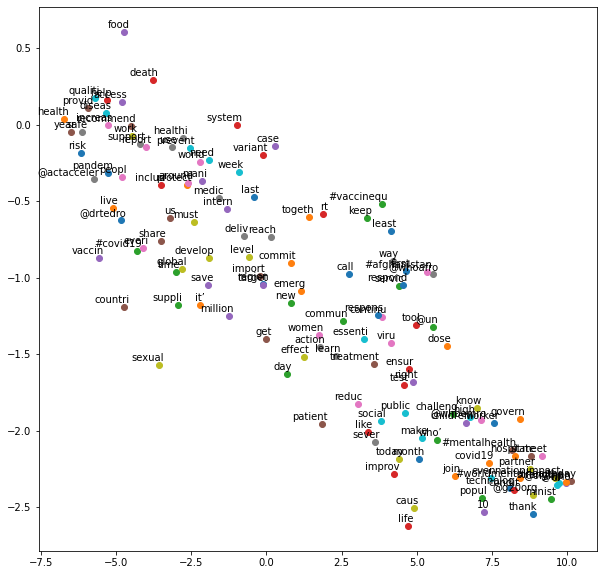

In [36]:
sentences = clean_tweets
model = Word2Vec(sentences, workers=4, min_count=50, window=10, sample=1e-3)
tsne_plot(model)